In [1]:
import json
import asyncio
import requests
import websockets
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import queue
import threading
import numpy as np

%matplotlib widget

In [2]:
orchestrator_url = "http://127.0.0.1:13390"
socket_url = "ws://127.0.0.1:13374/ws"

In [3]:
experiment_keys = [
    ("x", "y"),
    ("zre", "zim")
]
# the lower index the mroe important if more than one pair is present
#  in one measurement the lower index one is displayed

In [4]:
#start
#send this command to initialize the orchestrator for normal single experiments
collectionkey = 'default'
experiment = {'soe':['orchestrator/start'],'params':{'start':{'collectionkey':collectionkey}},'meta':{}}
requests.post(orchestrator_url+'/orchestrator/addExperiment',params = {'experiment':json.dumps(experiment)})

<Response [200]>

In [5]:
id0 = 0
substrate = -999
experiment = dict(soe=['orchestrator/start',  f'palmsens/measure_{0}', f'palmsens/measure_{1}'], 
            params={'start': {'collectionkey' : f'substrate_{substrate}'},
                    f'measure_{0}':{'method': 'open_circuit_potentiometry',
                                    'parameters': json.dumps({'t_run': 10, 't_interval': 0.25}),
                                    'filename': 'substrate_{}_dummy_ocp_{}_{}'.format(substrate, id0, 0),
                                    'substrate': substrate,
                                    'id': id0,
                                    'experiment': 0},
                    f'measure_{1}': {'method': 'potentiostatic_impedance_spectroscopy',
                                'parameters': json.dumps({
                                "e_dc": 0.0,
                                "e_ac": 0.01,
                                "n_frequencies": 11,
                                "max_frequency": 1e5,
                                "min_frequency": 1e4,
                                "meas_vs_ocp_true": 1,
                                "t_max_ocp": 5.0,
                                "stability_criterion": 0.001
                }),
                'filename': 'substrate_{}_dummy_eis_{}_{}'.format(substrate, id0, 0)}
                },
            meta=dict())
requests.post(orchestrator_url+'/orchestrator/addExperiment',params = {'experiment':json.dumps(experiment)})

<Response [200]>

C:\Users\juliu\AppData\Local\Temp\ipykernel_41048\3200432036.py:123: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update, init_func=init, blit=True, interval=10)


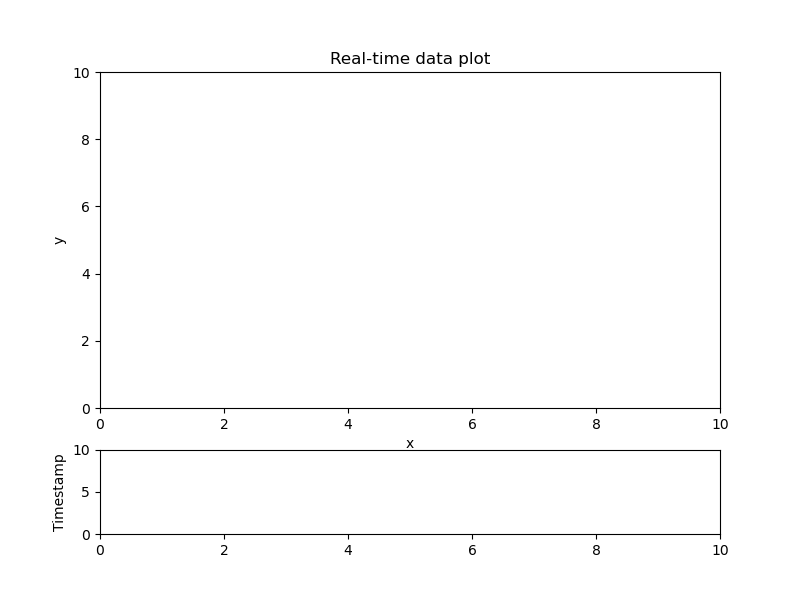

In [6]:
# Data queues
data_queue = queue.Queue()
received_data = []
xdata, ydata, timestamps = [], [], []
start_time = -1
index = -1
clear_flag = False
experiment_index = 0
label_x = "x"
label_y = "y"

# Data generator coroutine
async def data_generator(queue):
    global start_time
    global index
    global experiment_index
    global clear_flag
    global label_x
    global label_y
    async with websockets.connect(socket_url, ping_interval=None) as ws:
        while True:
            new_data = await ws.recv()
            await asyncio.sleep(0.1)
            new_data = json.loads(new_data)
            if isinstance(new_data, dict):
                received_data.append(new_data)
                if new_data["index"] <= index and index != -1:
                    experiment_index += 1
                    clear_flag = True
                index = new_data["index"]
                for keys_x, keys_y in experiment_keys:
                    if keys_x in new_data and keys_y in new_data:
                        x = new_data[keys_x]
                        y = new_data[keys_y]
                        if isinstance(x, list):
                            x = x[0]
                        if isinstance(y, list):
                            y = y[0]
                        
                        if start_time == -1:
                            start_time =  new_data["timestamp"] * 1000
                        
                        timestamp = new_data["timestamp"] * 1000 - start_time
                        label_x = keys_x
                        label_y = keys_y
                        queue.put_nowait((x, y, timestamp))
                        
                        break
            else:
                print(f"Received data is not a dictionary")

# Function to start the data generator in a separate thread
def start_data_generator():
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    loop.run_until_complete(data_generator(data_queue))



# Matplotlib plot setup
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), height_ratios=[4, 1])

line = ax1.scatter(xdata, ydata, color='r')
timestamps_line, = ax2.plot(timestamps, 'b-')

ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)

ax1.set_xlabel(label_x)
ax1.set_ylabel(label_y)
ax1.set_title('Real-time data plot')

ax2.set_ylabel('Timestamp')



# Initialization function for FuncAnimation
def init():
    #line.set_data([], [])
    timestamps_line.set_data([], [])
    return line, timestamps_line

# Update function for FuncAnimation
def update(frame):
    global line  # Declare line as global to update it in this function
    global clear_flag
    global label_x
    global label_y
    while not data_queue.empty():
        x, y, timestamp = data_queue.get_nowait()
        if clear_flag:
            xdata.clear()
            ydata.clear()
            timestamps.clear()
            clear_flag = False
        xdata.append(x)
        ydata.append(y)
        timestamps.append(timestamp)

    ax1.clear()  # Clear previous scatter plot
    ax1.set_xlabel(label_x)
    ax1.set_ylabel(label_y)
    ax1.set_title('Real-time data plot')
    x_min = min(xdata, default=0)
    x_max = max(xdata, default=10)
    y_min = min(ydata, default=0)
    y_max = max(ydata, default=10)
    ax1.set_xlim(x_min - 0.05 * abs(x_min), x_max + 0.05 * abs(x_max))
    ax1.set_ylim(y_min - 0.05 * abs(y_min), y_max + 0.05 * abs(y_max))
    line = ax1.scatter(xdata, ydata, color='r')  # Redraw scatter plot with updated data
    timestamps_line.set_data(range(len(timestamps)), timestamps)
    ax2.set_xlim(0, len(timestamps))
    ax2.set_ylim(min(timestamps, default=0), max(timestamps, default=10))
    return line, timestamps_line

# Start the data generator in a separate thread
thread = threading.Thread(target=start_data_generator)
thread.start()

# Start the animation
ani = animation.FuncAnimation(fig, update, init_func=init, blit=True, interval=10)
# Show the plot
plt.show()

In [20]:
x_unit_ = received_data[0]['x_unit']
x_type_ = received_data[0]['x_type']

In [21]:
f"{x_type_}, {x_unit_}"

'Time, s'